In [1]:
using LinearAlgebra, Random, StatsBase, Serialization, StableDistributions, LaTeXStrings, SharedArrays, MLDatasets
using CairoMakie, Colors, ColorSchemes
# using Plots
include("../AdL.jl"); include("../Ad2L.jl"); include("../force.jl");

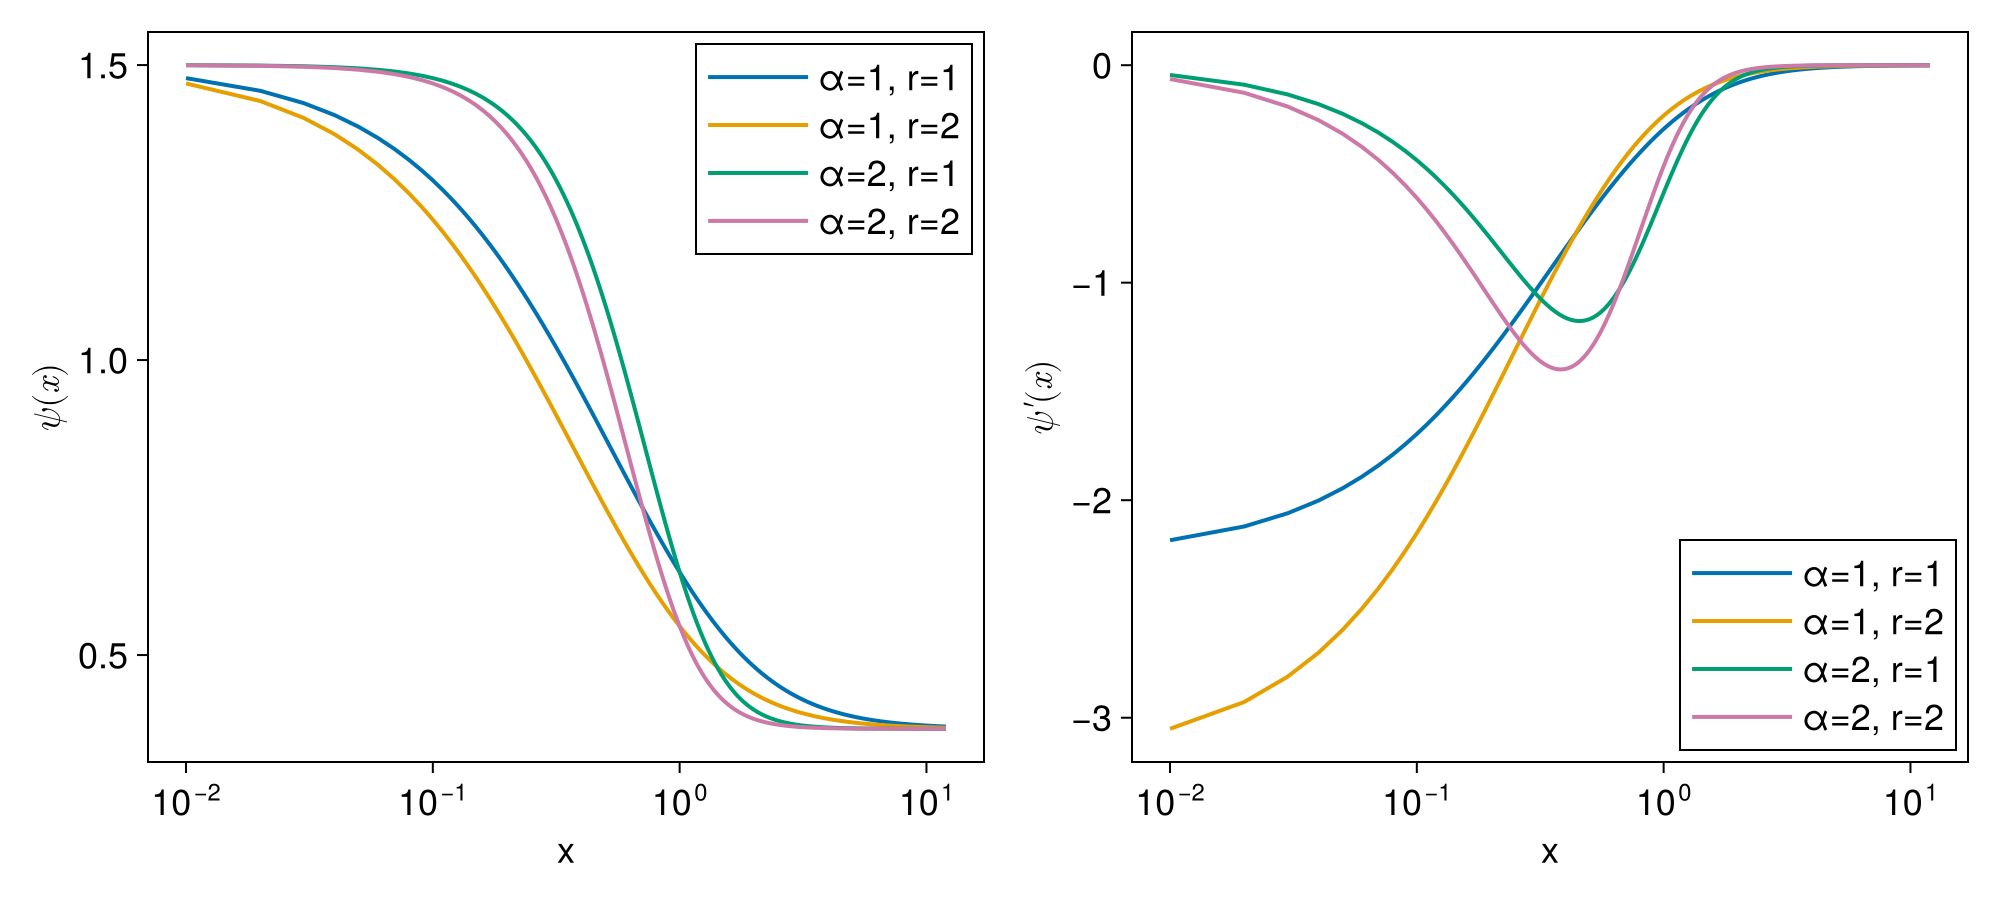

In [5]:
xx = 0.01:0.01:12.0
m = 0.5
M = 1.5

fig = Figure(size=(1000, 450), fontsize=18)

ax1 = Axis(fig[1, 1], xlabel="x", ylabel=L"\psi(x)", xscale = log10)
ax1.xgridvisible = false; ax1.ygridvisible = false
for a in [1, 2]
    for r in [1, 2]
        yy = psi.(xx, m, M, alpha = a, r = r)
        lines!(ax1, xx, yy, label="α=$a, r=$r", linewidth=2)
    end
end
axislegend(ax1, position=:rt, patchsize=(50, 20))

ax2 = Axis(fig[1, 2], xlabel="x", ylabel=L"\psi'(x)", xscale = log10)
ax2.xgridvisible = false; ax2.ygridvisible = false
for a in [1, 2]
    for r in [1, 2]
        yy = psi_prime.(xx, m, M, alpha = a, r = r)
        lines!(ax2, xx, yy, label="α=$a, r=$r", linewidth=2)
    end
end
axislegend(ax2, position=:rb, patchsize=(50, 20))
save("../psi.pdf", fig)
fig

In [4]:
function preprocess_data(data_x, data_y, rpm)
    input_dim = size(data_x, 1) * size(data_x, 2)
    ind = findall(x -> x == 7 || x == 9, data_y)

    y_data = data_y[ind]
    y_data = ifelse.(y_data .== 7, 1, -1)
    x_data = transpose(reshape(data_x, input_dim, size(data_x, 3))[:, ind])
    x_data = x_data * rpm
    return x_data, y_data
end

using MLDatasets

dim = 100
train_x, train_y = MNIST(split=:train)[:]
test_x, test_y = MNIST(split=:test)[:]
input_dim = size(train_x, 1) * size(train_x, 2)
rpm = random_projection_matrix(input_dim, dim)

train = hcat(preprocess_data(train_x, train_y, rpm)...)
x_test, y_test = preprocess_data(test_x, test_y, rpm)

([0.9142511373430553 -0.24724176292299585 … 0.5393130744553485 -1.3346979861041977; 0.908138009789873 -0.17863895677007408 … 1.3292640961377131 0.8341013361731844; … ; 1.621335401217674 0.7485176362454449 … 0.48225727815987757 -1.2348503462165947; -0.15282800606555552 -0.05501807990590574 … 0.3973528486453813 -0.42112608344426417], [1, -1, -1, -1, -1, 1, -1, 1, 1, 1  …  1, -1, 1, 1, 1, 1, -1, 1, 1, -1])

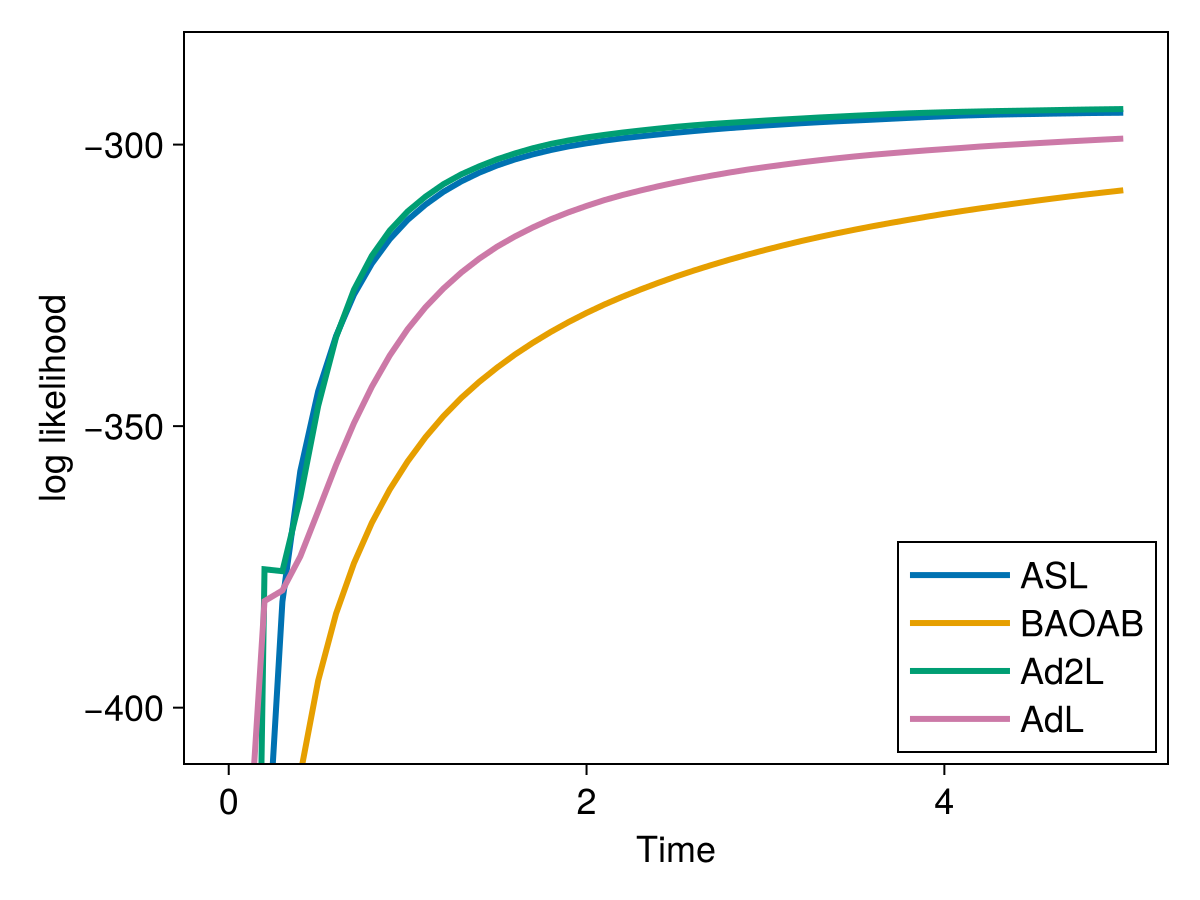

In [26]:
traj_len = 50; T = 5; h = 0.001; m = 0.1
T_lst = collect(range(0,T,length=traj_len+1))
llh_init = log_likelihood_BLR(zeros(100), x_test, y_test)
log_likelihood_ASL = open(deserialize, "data/log_likelihood_ASL_h="*string(h)*".jls"); log_likelihood_ASL = [mean(log_likelihood_ASL[i,:]) for i in 1:traj_len];
log_likelihood_BAOAB = open(deserialize, "data/log_likelihood_BAOAB_h="*string(h)*".jls"); log_likelihood_BAOAB = [mean(log_likelihood_BAOAB[i,:]) for i in 1:traj_len];
log_likelihood_Ad2L = open(deserialize, "data/log_likelihood_Ad2L_h="*string(h)*".jls"); log_likelihood_Ad2L = [mean(log_likelihood_Ad2L[i,:]) for i in 1:traj_len];
log_likelihood_AdL = open(deserialize, "data/log_likelihood_AdL_h="*string(h)*".jls"); log_likelihood_AdL = [mean(log_likelihood_AdL[i,:]) for i in 1:traj_len];
g_avg_ASL = open(deserialize, "data/g_avg_ASL_BLR_h="*string(h)*".jls"); g_avg_ASL = [mean(g_avg_ASL[i,:]) for i in 1:traj_len]
g_avg_Ad2L = open(deserialize, "data/g_avg_Ad2L_BLR_h="*string(h)*".jls"); g_avg_Ad2L = [mean(g_avg_Ad2L[i,:]) for i in 1:traj_len]
log_likelihood_ASL = vcat([llh_init], log_likelihood_ASL); log_likelihood_BAOAB = vcat([llh_init], log_likelihood_BAOAB); log_likelihood_Ad2L = vcat([llh_init], log_likelihood_Ad2L); log_likelihood_AdL = vcat([llh_init], log_likelihood_AdL)
# g_avg_ASL = vcat([0.0], g_avg_ASL); g_avg_Ad2L = vcat([0.0], g_avg_Ad2L); 

fig = Figure(size=(600, 450), fontsize=18)
ax = Axis(fig[1, 1], xlabel="Time", ylabel="log likelihood")
ax.xgridvisible = false; ax.ygridvisible = false

lines!(ax, T_lst, log_likelihood_ASL, label="ASL", linewidth=3)
lines!(ax, T_lst, log_likelihood_BAOAB, label="BAOAB", linewidth=3)
lines!(ax, T_lst, log_likelihood_Ad2L, label="Ad2L", linewidth=3)
lines!(ax, T_lst, log_likelihood_AdL, label="AdL", linewidth=3)

ylims!(ax, -410, -280)
# ylims!(ax, -292, -278)
axislegend(ax, fontsize=28, position=:rb, patchsize = (50, 20))
# save("log_likelihood_m="*string(m)*"_h="*string(h)*".pdf", fig)
fig

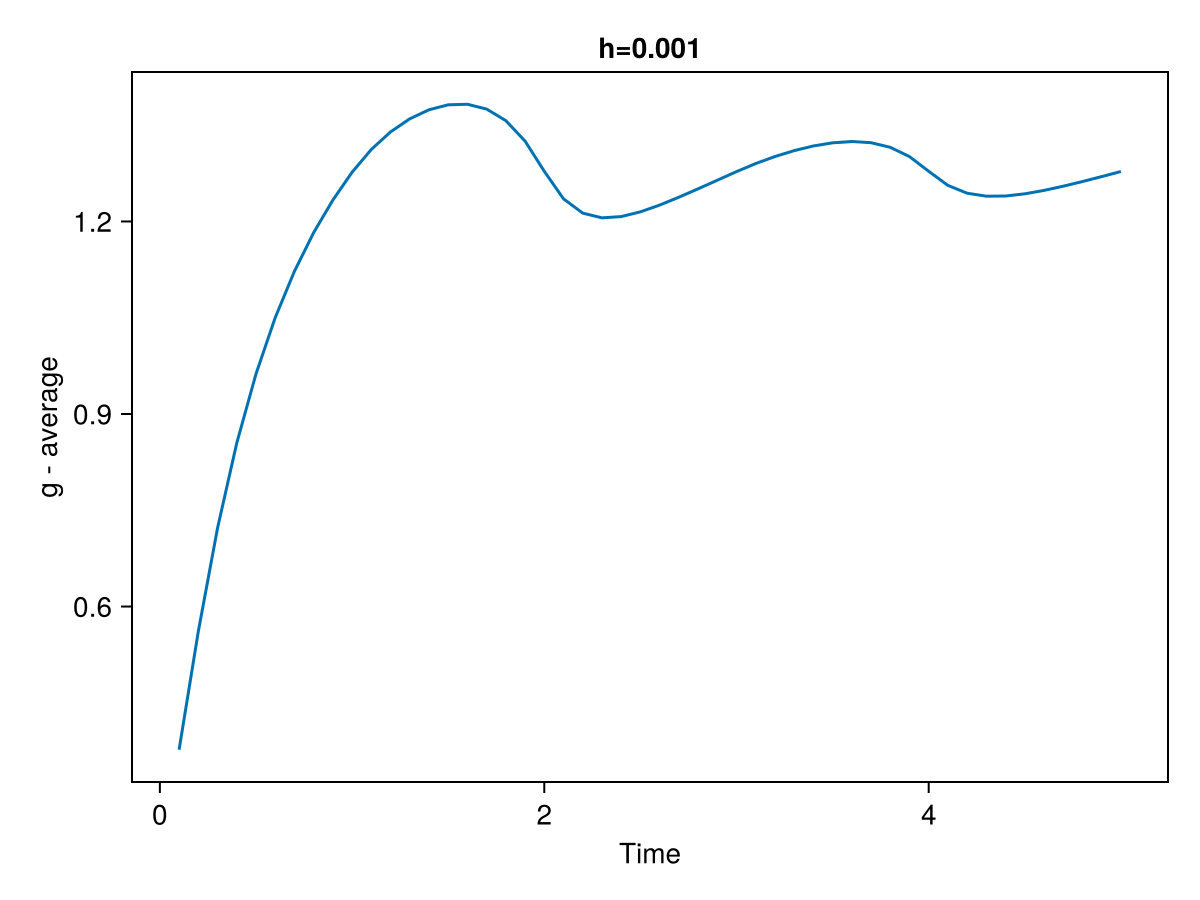

In [27]:
fig = Figure(size=(600, 450))
ax = Axis(fig[1, 1], xlabel="Time", ylabel="g - average", title="h="*string(h))
ax.xgridvisible = false; ax.ygridvisible = false
lines!(ax, T_lst[2:end], g_avg_ASL, label="ASL")
# lines!(ax, T_lst[2:end], g_avg_Ad2L, label="Ad2L")

# axislegend(ax, position=:rc, patchsize = (50, 20))
# save("g_avg_BLR_h="*string(h)*".pdf", fig)
fig

In [28]:
mean(g_avg_ASL)

1.2156143087556668

In [43]:
using Distributed
# addprocs(15)
@everywhere begin
    using LinearAlgebra, Random, StatsBase, Serialization, Distributions, LaTeXStrings, SharedArrays
    include("../AdL.jl"); include("../Ad2L.jl"); include("../force.jl");
end

function save_variable(var, file_name)
    variable = copy(var)
    name = string(file_name, ".jls")
    open(name, "w") do file
        serialize(file, variable)
    end
end

@everywhere function run_predict_ASL(Nsteps, h, γ, beta, Samples, m, M; traj_len=50)
    dim = size(Samples, 2) - 1
    q0 = zeros(dim); p0 = randn(dim)/10; q = copy(q0); p = copy(p0)
    xi = copy(γ); sigma_A = sqrt(2*γ/beta)
    q_mean = zeros(dim); q_mean_traj = zeros(dim, traj_len); g_avg_traj = zeros(traj_len); g_avg = 0.0
    bi_idx = 0  # no burn-in
    rec = (Nsteps-bi_idx) ÷ traj_len; p_num = 0

    n = 50; N = size(Samples, 1)  # initial case
    idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)
    # tmp, tmp_prime = get_monitor_prime(q, data); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * tmp_prime
    tmp = sqrt(N)/n; g = psi(tmp, m, M); g_prime = zeros(dim)

    for i in 1:Nsteps
        p = B_step_hat(q, p, xi, h, g, g_prime, force, beta)
        q = A_step(q, p, xi, g*h)  # A_step_hat(q, p, xi, h, g, g_prime, data)
        # tmp = get_monitor(q, data); g = psi(tmp, m, M)
        g_avg += g
        p = O_step_hat(q, p, xi, h, g, g_prime, sigma_A)
        q = A_step(q, p, xi, g*h)  # A_step_hat(q, p, xi, h, g, g_prime, data)
        n = cyclic_n(i - bi_idx)
        idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)
        # tmp, tmp_prime = get_monitor_prime(q, data); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * tmp_prime
        tmp = sqrt(N)/n; g = psi(tmp, m, M)
        g_avg += g
        p = B_step_hat(q, p, xi, h, g, g_prime, force, beta)

        if i > bi_idx
            q_mean += q
            if i % rec == 0
                p_num += 1
                q_mean_traj[:,p_num] = q_mean ./ (i - bi_idx)
                g_avg_traj[p_num] = g_avg / (i*2)
                if p_num == traj_len
                    break
                end
            end
        end
    end
    return q_mean_traj, g_avg_traj
end

@everywhere function run_predict_BAOAB(Nsteps, h, γ, beta, Samples; traj_len=50)
    N = size(Samples, 1); dim = size(Samples, 2) - 1
    q0 = zeros(dim); p0 = randn(dim)/10; q = copy(q0); p = copy(p0)
    xi = copy(γ); sigma_A = sqrt(2*γ/beta)
    q_mean = zeros(dim); q_mean_traj = zeros(dim, traj_len)
    bi_idx = 0  # no burn-in
    rec = (Nsteps-bi_idx) ÷ traj_len; p_num = 0
    n = 50; idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n); 

    for i in 1:Nsteps
        p = B_step(q, p, xi, h/2, force)
        q = A_step(q, p, xi, h/2)
        p = O_step(q, p, xi, h, sigma_A)
        q = A_step(q, p, xi, h/2)
        n = cyclic_n(i - bi_idx)
        idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)
        p = B_step(q, p, xi, h/2, force)
        if i > bi_idx
            q_mean += q
            if i % rec == 0
                p_num += 1
                q_mean_traj[:,p_num] = q_mean ./ (i - bi_idx)
                if p_num == traj_len
                    break
                end
            end
        end
    end
    return q_mean_traj
end

@everywhere function run_predict_Ad2L(Nsteps, h, sigma_A, mu, beta, Nd, Samples, m, M; traj_len=50)
    N = size(Samples, 1); dim = size(Samples, 2) - 1
    q0 = zeros(dim); p0 = randn(dim)/10; xi0 = randn() 
    q = copy(q0); p = copy(p0); xi = copy(xi0)
    q_mean = zeros(dim); q_mean_traj = zeros(dim, traj_len); g_avg_traj = zeros(traj_len); g_avg = 0.0
    bi_idx = 0  # no burn-in
    rec = (Nsteps-bi_idx) ÷ traj_len; p_num = 0
    
    n = 50; N = size(Samples, 1)  # initial case
    idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)
    # tmp, tmp_prime = get_monitor_prime(q, data); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * tmp_prime
    tmp = sqrt(N)/n; g = psi(tmp, m, M); g_prime = zeros(dim)

    for i in 1:Nsteps
        p = B_step_hat(q, p, xi, h, g, g_prime, force, beta)
        q = A_step(q, p, xi, g*h)  # A_step_hat(q, p, xi, h, g, g_prime, data)
        # tmp = get_monitor(q, data); g = psi(tmp, m, M)
        g_avg += g
        xi = D_step_hat(q, p, xi, h, g, g_prime, mu, beta, Nd)
        p = O_step_hat(q, p, xi, h, g, g_prime, sigma_A)
        xi = D_step_hat(q, p, xi, h, g, g_prime, mu, beta, Nd)
        q = A_step(q, p, xi, g*h)  # A_step_hat(q, p, xi, h, g, g_prime, data)
        n = cyclic_n(i - bi_idx)
        idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)
        # tmp, tmp_prime = get_monitor_prime(q, data); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * tmp_prime
        tmp = sqrt(N)/n; g = psi(tmp, m, M)
        g_avg += g
        p = B_step_hat(q, p, xi, h, g, g_prime, force, beta)

        if i > bi_idx
            q_mean += q
            if i % rec == 0
                p_num += 1
                q_mean_traj[:,p_num] = q_mean ./ (i - bi_idx)
                g_avg_traj[p_num] = g_avg / (i*2)
                if p_num == traj_len
                    break
                end
            end
        end
    end
    return q_mean_traj, g_avg_traj
end

@everywhere function run_predict_AdL(Nsteps, h, sigma_A, mu, beta, Nd, Samples; traj_len=50)
    N = size(Samples, 1); dim = size(Samples, 2) - 1
    q0 = zeros(dim); p0 = randn(dim)/10; xi0 = randn() 
    q = copy(q0); p = copy(p0); xi = copy(xi0)
    q_mean = zeros(dim); q_mean_traj = zeros(dim, traj_len)
    bi_idx = 0  # no burn-in
    rec = (Nsteps-bi_idx) ÷ traj_len; p_num = 0
    n = 50; idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)

    for i in 1:Nsteps
        p = B_step(q, p, xi, h/2, force)
        q = A_step(q, p, xi, h/2)
        xi = D_step(q, p, xi, h/2, mu, beta, Nd)
        p = O_step(q, p, xi, h, sigma_A)
        xi = D_step(q, p, xi, h/2, mu, beta, Nd)
        q = A_step(q, p, xi, h/2)
        n = cyclic_n(i - bi_idx)
        idx = randperm(N)[1:n]; data = Samples[idx,:]; force = -grad_BLR(data, q, N, n)
        p = B_step(q, p, xi, h/2, force)
        if i > bi_idx
            q_mean += q
            if i % rec == 0
                p_num += 1
                q_mean_traj[:,p_num] = q_mean ./ (i - bi_idx)
                if p_num == traj_len
                    break
                end
            end
        end
    end
    return q_mean_traj
end

function preprocess_data(data_x, data_y, rpm)
    input_dim = size(data_x, 1) * size(data_x, 2)
    ind = findall(x -> x == 7 || x == 9, data_y)

    y_data = data_y[ind]
    y_data = ifelse.(y_data .== 7, 1, -1)
    x_data = transpose(reshape(data_x, input_dim, size(data_x, 3))[:, ind])
    x_data = x_data * rpm
    return x_data, y_data
end

using MLDatasets

dim = 100
train_x, train_y = MNIST(split=:train)[:]
test_x, test_y = MNIST(split=:test)[:]
input_dim = size(train_x, 1) * size(train_x, 2)
rpm = random_projection_matrix(input_dim, dim)

train = hcat(preprocess_data(train_x, train_y, rpm)...)
x_test, y_test = preprocess_data(test_x, test_y, rpm)

@everywhere begin
    global train = $train
    global x_test = $x_test
    global y_test = $y_test
    # cyclic_n = i -> 50 + mod(i, 1000)  # mod(i, 200) < 100 ? 50 : 500
    function cyclic_n(i, max_value=500, base_value=50)
        mod_i = mod(i - 1, 2 * max_value) + 1
        if mod_i <= max_value
            n = mod_i
        else
            n = 2 * max_value - mod_i + 1
        end
        return n + base_value
    end

    repeats = 60; num_cores = nprocs()
    t = 5; h = 0.0003; Nsteps = round(Int, t/h); m = 0.1; M = 1.8
    sigma_A = 9.0; mu = 10; γ = 100.0; beta = 1.0; Nd = dim
    traj_len = 100
end

log_likelihood_matrix1 = SharedArray{Float64}(traj_len, repeats); g_avg_matrix1 = SharedArray{Float64}(traj_len, repeats)
log_likelihood_matrix2 = SharedArray{Float64}(traj_len, repeats);
log_likelihood_matrix3 = SharedArray{Float64}(traj_len, repeats); g_avg_matrix3 = SharedArray{Float64}(traj_len, repeats)
log_likelihood_matrix4 = SharedArray{Float64}(traj_len, repeats);

println("Number of processes: ", nprocs())
println("Worker process IDs: ", workers())

@sync @distributed for core in 1:num_cores
    for k in core:num_cores:repeats
        q_mean_traj1, g_avg_traj1 = run_predict_ASL(Nsteps, h, γ, beta, train, m, M; traj_len=traj_len)
        q_mean_traj2 = run_predict_BAOAB(Nsteps, h, γ, beta, train, traj_len = traj_len)
        q_mean_traj3, g_avg_traj3 = run_predict_Ad2L(Nsteps, h, sigma_A, mu, beta, Nd, train, m, M; traj_len=traj_len)
        q_mean_traj4 = run_predict_AdL(Nsteps, h, sigma_A, mu, beta, Nd, train, traj_len = traj_len)
        log_likelihood_matrix1[:,k] = [log_likelihood_BLR(q_mean_traj1[:,j], x_test, y_test) for j in 1:traj_len]
        log_likelihood_matrix2[:,k] = [log_likelihood_BLR(q_mean_traj2[:,j], x_test, y_test) for j in 1:traj_len]
        log_likelihood_matrix3[:,k] = [log_likelihood_BLR(q_mean_traj3[:,j], x_test, y_test) for j in 1:traj_len]
        log_likelihood_matrix4[:,k] = [log_likelihood_BLR(q_mean_traj4[:,j], x_test, y_test) for j in 1:traj_len]
        g_avg_matrix1[:,k] = g_avg_traj1; g_avg_matrix3[:,k] = g_avg_traj3
    end
end  

save_variable(log_likelihood_matrix1, "data/log_likelihood_ASL_h="*string(h)); save_variable(g_avg_matrix1, "data/g_avg_ASL_BLR_h="*string(h))
save_variable(log_likelihood_matrix2, "data/log_likelihood_BAOAB_h="*string(h));
save_variable(log_likelihood_matrix3, "data/log_likelihood_Ad2L_h="*string(h)); save_variable(g_avg_matrix1, "data/g_avg_Ad2L_BLR_h="*string(h))
save_variable(log_likelihood_matrix4, "data/log_likelihood_AdL_h="*string(h));

println("fin")

Number of processes: 16
Worker process IDs: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
fin
